In [ ]:
# Step 1 — Imports & settings
from __future__ import annotations

import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pandas display tweaks (handy in notebooks)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Minimal logger for notebooks (INFO by default)
import logging
logger = logging.getLogger("tt_explore")
if not logger.handlers:
    h = logging.StreamHandler()
    h.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
    logger.addHandler(h)
logger.setLevel(logging.INFO)

# Project paths
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
assert DATA_RAW.exists(), f"Raw data folder not found: {DATA_RAW}"
logger.info(f"Project root: {PROJECT_ROOT}")
logger.info(f"Raw data dir: {DATA_RAW}")

[INFO] Project root: c:\Users\Bálint\Documents\Pet_projects\tastetrend_analytics_genai
[INFO] Raw data dir: c:\Users\Bálint\Documents\Pet_projects\tastetrend_analytics_genai\data\raw


In [2]:
# Step 2 — Column name mapping
# Unified schema target
STANDARD_COLS = [
    "review_id", "customer_name", "review_date", "rating_raw", "rating_scale",
    "rating_1_5", "review_text", "location", "restaurant_name",
    "total_spent", "tip_amount", "tip_percentage", "party_size",
    "age_range", "gender", "ethnicity", "source_file"
]

# Synonym dictionary: maps unified column -> possible raw names (lowercased)
SYNONYMS: Dict[str, List[str]] = {
    "review_id": ["review_id", "review_number", "id"],
    "customer_name": ["customer_name", "guest_name", "name"],
    "review_date": ["date", "visit_date", "review_date"],
    "rating_raw": ["rating", "satisfaction_score", "rating_out_of_10", "star_rating"],
    "review_text": ["review_text", "feedback_comments", "comments"],
    "location": ["location", "venue_location", "venue"],
    "restaurant_name": ["restaurant_name", "business_name", "establishment"],
    "total_spent": ["total_spent"],
    "tip_amount": ["tip_amount"],
    "tip_percentage": ["tip_percentage"],
    "party_size": ["party_size"],
    "age_range": ["age_range"],
    "gender": ["gender"],
    "ethnicity": ["ethnicity"],
}


In [3]:
# Step 3 — Reusable helpers

def read_table_any(path: Path) -> pd.DataFrame:
    """
    Read CSV/TXT with sensible defaults. Auto-detect delimiter for .txt.
    """
    path = Path(path)
    if path.suffix.lower() in {".csv", ".txt"}:
        try:
            if path.suffix.lower() == ".txt":
                # Try auto delimiter detection
                df = pd.read_csv(path, sep=None, engine="python")
            else:
                df = pd.read_csv(path)
        except Exception as e:
            logger.warning(f"Auto read failed for {path.name}, retrying with comma sep. Error: {e}")
            df = pd.read_csv(path, sep=",")
        return df
    raise ValueError(f"Unsupported file type: {path.name}")

def normalize_colname(c: str) -> str:
    """
    Lowercase + strip + collapse spaces/underscores for robust matching.
    """
    c = c.strip().lower()
    c = re.sub(r"[\s]+", "_", c)
    return c

def build_colmap(raw_cols: List[str], synonyms: Dict[str, List[str]]) -> Dict[str, str]:
    """
    Given raw column names, build a map: unified_name -> raw_name (if present).
    """
    raw_norm = {normalize_colname(c): c for c in raw_cols}
    mapping = {}
    for unified, alts in synonyms.items():
        for alt in alts:
            alt_norm = normalize_colname(alt)
            if alt_norm in raw_norm:
                mapping[unified] = raw_norm[alt_norm]
                break
    return mapping

def coerce_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def coerce_str(s: pd.Series) -> pd.Series:
    return s.astype("string").str.strip()

def coerce_date(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)

def infer_rating_scale(series: pd.Series) -> int:
    """
    Heuristic: decide the scale (5/10/100) from observed values.
    """
    vals = pd.to_numeric(series, errors="coerce")
    vmax = vals.max(skipna=True)
    if pd.isna(vmax):
        return 5
    if vmax > 10 and vmax <= 100:
        return 100
    if vmax > 5 and vmax <= 10:
        return 10
    return 5

def compute_tip_pct(df: pd.DataFrame) -> pd.DataFrame:
    """
    If tip_percentage is missing but total_spent & tip_amount exist, derive it.
    """
    if "tip_percentage" in df.columns:
        # fill only where missing/zero
        needs = df["tip_percentage"].isna() | (df["tip_percentage"] == 0)
    else:
        df["tip_percentage"] = np.nan
        needs = df["tip_percentage"].isna()
    mask = needs & df["total_spent"].gt(0) & df["tip_amount"].notna()
    df.loc[mask, "tip_percentage"] = (df.loc[mask, "tip_amount"] / df.loc[mask, "total_spent"]) * 100.0
    return df


In [4]:
# Step 4 — Thin class to standardize each file consistently

@dataclass
class FileSpec:
    path: Path
    source_name: str  # e.g., "downtown", "eastside", ...

class ReviewLoader:
    def __init__(self, synonyms: Dict[str, List[str]]):
        self.synonyms = synonyms
        self.schema_audit_rows: List[Dict[str, str]] = []

    def load_and_standardize(self, spec: FileSpec) -> pd.DataFrame:
        df_raw = read_table_any(spec.path)
        df_raw.columns = [normalize_colname(c) for c in df_raw.columns]

        # Build mapping raw -> unified
        mapping = build_colmap(list(df_raw.columns), self.synonyms)

        # Start an output frame with mapped columns
        selected = {}
        for unified, raw_col in mapping.items():
            selected[unified] = df_raw[raw_col]
            # for audit
            self.schema_audit_rows.append({
                "source_file": spec.path.name,
                "unified_col": unified,
                "raw_col": raw_col
            })
        df = pd.DataFrame(selected)

        # Add source file tag
        df["source_file"] = spec.path.name

        # Coerce obvious types
        if "customer_name" in df.columns: df["customer_name"] = coerce_str(df["customer_name"])
        if "review_text" in df.columns:   df["review_text"]   = coerce_str(df["review_text"])
        if "location" in df.columns:      df["location"]      = coerce_str(df["location"])
        if "restaurant_name" in df.columns: df["restaurant_name"] = coerce_str(df["restaurant_name"])

        # Dates
        if "review_date" in df.columns:   df["review_date"]   = coerce_date(df["review_date"])

        # Money / numerics
        for c in ["total_spent", "tip_amount", "tip_percentage", "party_size"]:
            if c in df.columns:
                df[c] = coerce_numeric(df[c])

        # Ratings: keep raw + inferred scale + normalized 1–5
        if "rating_raw" in df.columns:
            df["rating_raw"] = coerce_numeric(df["rating_raw"])
            scale = infer_rating_scale(df["rating_raw"])
            df["rating_scale"] = scale
            df["rating_1_5"] = (df["rating_raw"] / scale) * 5.0
        else:
            df["rating_raw"] = np.nan
            df["rating_scale"] = np.nan
            df["rating_1_5"] = np.nan

        # Derive tip_percentage if missing
        if {"total_spent", "tip_amount"}.issubset(df.columns):
            df = compute_tip_pct(df)

        # Normalize a few categoricals
        for c in ["gender", "ethnicity", "age_range"]:
            if c in df.columns:
                df[c] = coerce_str(df[c]).str.lower()

        # Ensure all standard columns exist (fill with NaN)
        for c in STANDARD_COLS:
            if c not in df.columns:
                df[c] = np.nan

        # Order columns for readability
        df = df[STANDARD_COLS]
        return df

    def schema_audit(self) -> pd.DataFrame:
        return pd.DataFrame(self.schema_audit_rows).sort_values(["source_file", "unified_col"])


In [5]:
# Step 5 — Load all raw files and standardize

files = [
    FileSpec(DATA_RAW / "tastetrend_downtown_reviews.csv", "downtown"),
    FileSpec(DATA_RAW / "tastetrend_eastside_reviews.csv", "eastside"),
    FileSpec(DATA_RAW / "tastetrend_midtown_reviews.txt", "midtown"),
    FileSpec(DATA_RAW / "tastetrend_uptown_reviews.csv", "uptown"),
]

loader = ReviewLoader(SYNONYMS)

frames = []
for spec in files:
    logger.info(f"Loading {spec.path.name}")
    df_std = loader.load_and_standardize(spec)
    logger.info(f" -> rows: {len(df_std):,}, cols: {len(df_std.columns)}")
    # quick peek
    display(df_std.head(3))
    frames.append(df_std)

# Concatenated master dataset (exploration only)
reviews = pd.concat(frames, ignore_index=True)
logger.info(f"Combined rows: {len(reviews):,}")
display(reviews.sample(5, random_state=42))


[INFO] Loading tastetrend_downtown_reviews.csv
C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\3384624947.py:50: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
[INFO]  -> rows: 614, cols: 17


,review_id,customer_name,review_date,rating_raw,rating_scale,rating_1_5,review_text,location,restaurant_name,total_spent,tip_amount,tip_percentage,party_size,age_range,gender,ethnicity,source_file
0,3kw_ThR91_nHM_CGMhkaZg,Customer_4505,2011-04-27 18:46:45,4.0,5,4.0,"I haven't been here in a long long time, but w...",Downtown,Village Whiskey,32.05,5.55,17.3,3,46-55,non-binary,<NA>,tastetrend_downtown_reviews.csv
1,RxF95SA7xWmQHH8nQ4aa9g,Customer_7381,2010-03-19 23:43:48,4.0,5,4.0,Expect to feel guilty after leaving this place...,Downtown,Village Whiskey,14.34,5.74,40.0,2,65+,male,other,tastetrend_downtown_reviews.csv
2,X6mPOoNHvvxp7a6uC8FWtg,Customer_5892,2010-01-28 20:56:07,3.0,5,3.0,I read all the reviews for VW and I guess mayb...,Downtown,Village Whiskey,29.32,7.59,25.9,1,<NA>,prefer not to say,asian,tastetrend_downtown_reviews.csv


[INFO] Loading tastetrend_eastside_reviews.csv
C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\3384624947.py:50: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
[INFO]  -> rows: 1,784, cols: 17


,review_id,customer_name,review_date,rating_raw,rating_scale,rating_1_5,review_text,location,restaurant_name,total_spent,tip_amount,tip_percentage,party_size,age_range,gender,ethnicity,source_file
0,xZnk3q-AHjpN6aSR_6Sqhg,Guest_6617,2011-11-02,5.0,5,5.0,<NA>,Eastside,The Bricks,22.25,3.99,17.9,3,<NA>,non-binary,other,tastetrend_eastside_reviews.csv
1,2umV3kR4UxjuYV4wU7Qw1w,Guest_6307,NaT,4.0,5,4.0,<NA>,Eastside,The Bricks,8.83,1.47,16.7,2,26-35,prefer not to say,native american,tastetrend_eastside_reviews.csv
2,hBzLjPySOBHDz0NiGf6SfQ,Guest_8824,NaT,4.0,5,4.0,Friendly service & neat building. Depending on...,Eastside,The Bricks,20.20,3.23,16.0,2,36-45,non-binary,african american,tastetrend_eastside_reviews.csv


[INFO] Loading tastetrend_midtown_reviews.txt
C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\3384624947.py:50: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
[INFO]  -> rows: 871, cols: 17


,review_id,customer_name,review_date,rating_raw,rating_scale,rating_1_5,review_text,location,restaurant_name,total_spent,tip_amount,tip_percentage,party_size,age_range,gender,ethnicity,source_file
0,RO4a3GrqJ7NM6TW07U-R9Q,Customer_8201,2014-08-30 03:28:01,8.0,10,4.0,<NA>,Midtown,Luke,NaN,5.87,23.1,4,36-45,non-binary,<NA>,tastetrend_midtown_reviews.txt
1,zuqMNagy_joYqkxt7ip4Pg,Customer_8595,2014-05-11 23:16:51,10.0,10,5.0,<NA>,Midtown,Luke,NaN,6.26,20.4,8,46-55,male,hispanic,tastetrend_midtown_reviews.txt
2,dd6yIkdKo8KNcl9z_LJWZA,Customer_6299,2010-12-10 00:41:45,10.0,10,5.0,<NA>,Midtown,Luke,29.61,4.73,16.0,2,<NA>,prefer not to say,asian,tastetrend_midtown_reviews.txt


[INFO] Loading tastetrend_uptown_reviews.csv
C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\3384624947.py:50: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
[INFO]  -> rows: 1,655, cols: 17


,review_id,customer_name,review_date,rating_raw,rating_scale,rating_1_5,review_text,location,restaurant_name,total_spent,tip_amount,tip_percentage,party_size,age_range,gender,ethnicity,source_file
0,9tGxCSt6z-ZPeJFxoc_T4A,Customer_6016,2015-12-23 16:23:07,NaN,5,NaN,"I've been here twice now, and the food is alwa...",Uptown,Tavern,39.72,11.92,30.0,2,65+,male,<NA>,tastetrend_uptown_reviews.csv
1,kVPUow1BON0KfPzndxW57w,Customer_4496,2018-07-09 00:09:28,NaN,5,NaN,<NA>,Uptown,Tavern,50.81,3.86,7.6,2,56-65,non-binary,hispanic,tastetrend_uptown_reviews.csv
2,F44PdlI3I-6QmnOMkUE-Mw,Customer_7373,2016-06-12 18:12:17,NaN,5,NaN,<NA>,Uptown,Tavern,34.66,7.12,20.5,1,36-45,female,asian,tastetrend_uptown_reviews.csv


[INFO] Combined rows: 4,924


,review_id,customer_name,review_date,rating_raw,rating_scale,rating_1_5,review_text,location,restaurant_name,total_spent,tip_amount,tip_percentage,party_size,age_range,gender,ethnicity,source_file
373,3Vh527hP7xG_7IHprPjgnQ,Customer_7461,2012-08-15 18:54:52,4.0,5,4.0,I have been trying to come here for what seems...,Downtown,Village Whiskey,40.99,8.66,21.1,2,56-65,male,other,tastetrend_downtown_reviews.csv
4920,Z_3i08PB4aHIoyJL_HEfHg_dup,Customer_2908,2017-05-02 00:56:49,NaN,5,NaN,<NA>,Uptown,Tavern,57.38,4.74,8.3,3,56-65,prefer not to say,<NA>,tastetrend_uptown_reviews.csv
756,jE2zHov_2Eii9XrrmkSV5g,Guest_9732,NaT,3.0,5,3.0,<NA>,Eastside,The Bricks,18.16,2.26,12.4,2,26-35,prefer not to say,other,tastetrend_eastside_reviews.csv
4147,W-1KsTFiqHEz5DdsnFEbiQ,Customer_7356,2015-01-06 02:19:19,NaN,5,NaN,"Great food, great atmosphere. I had the mac a...",Uptown,Tavern,127.99,28.30,22.1,2,26-35,non-binary,caucasian,tastetrend_uptown_reviews.csv
4310,LziEMdQo2jfSxlg0n_hVXQ,Customer_1091,2012-12-05 15:35:01,NaN,5,NaN,Delicious! I had a burger and my wife got the ...,Uptown,Tavern,54.21,7.19,13.3,2,46-55,non-binary,asian,tastetrend_uptown_reviews.csv


In [6]:
# Step 6 — Schema audit: which raw columns mapped to which unified column?
audit = loader.schema_audit()
display(audit)

# Missingness overview (% of NaNs per column)
missing_pct = reviews.isna().mean().sort_values(ascending=False)
display(missing_pct.to_frame("missing_pct").style.format("{:.1%}"))

# Empty-string counts for text fields (sometimes present even if not NaN)
for c in ["customer_name", "review_text", "location", "restaurant_name"]:
    if c in reviews.columns:
        empty = (reviews[c].astype("string").fillna("").str.len() == 0).sum()
        logger.info(f"Empty strings in {c}: {empty:,}")

# Basic numeric sanity checks
summary = reviews[["rating_raw", "rating_scale", "rating_1_5", "total_spent", "tip_amount", "tip_percentage", "party_size"]].describe()
display(summary)

# Quick check: rating scales by source_file (should mostly be 5/10/100)
scale_by_source = reviews.groupby("source_file")["rating_scale"].agg(["min", "max", "nunique"])
display(scale_by_source)


,source_file,unified_col,raw_col
11,tastetrend_downtown_reviews.csv,age_range,age_range
1,tastetrend_downtown_reviews.csv,customer_name,customer_name
13,tastetrend_downtown_reviews.csv,ethnicity,ethnicity
12,tastetrend_downtown_reviews.csv,gender,gender
5,tastetrend_downtown_reviews.csv,location,location
10,tastetrend_downtown_reviews.csv,party_size,party_size
3,tastetrend_downtown_reviews.csv,rating_raw,rating
6,tastetrend_downtown_reviews.csv,restaurant_name,business_name
2,tastetrend_downtown_reviews.csv,review_date,date
0,tastetrend_downtown_reviews.csv,review_id,review_id


,missing_pct
rating_raw,40.9%
rating_1_5,40.9%
review_text,30.5%
age_range,24.7%
review_date,24.4%
gender,20.0%
ethnicity,13.4%
total_spent,10.7%
customer_name,7.1%
review_id,0.0%


[INFO] Empty strings in customer_name: 350
[INFO] Empty strings in review_text: 1,501
[INFO] Empty strings in location: 0
[INFO] Empty strings in restaurant_name: 0


,rating_raw,rating_scale,rating_1_5,total_spent,tip_amount,tip_percentage,party_size
count,2912.000000,4924.000000,2912.000000,4398.000000,4924.000000,4924.000000,4924.000000
mean,5.029190,5.884444,3.972184,36.317021,6.666499,18.681885,2.731722
std,2.395212,1.908066,1.117726,24.020718,5.590409,7.796916,1.413395
min,1.000000,5.000000,1.000000,5.000000,0.000000,0.000000,1.000000
25%,4.000000,5.000000,4.000000,19.660000,3.090000,14.400000,2.000000
50%,4.000000,5.000000,4.000000,30.160000,5.200000,18.200000,2.000000
75%,5.000000,5.000000,5.000000,45.700000,8.430000,22.200000,4.000000
max,10.000000,10.000000,5.000000,213.390000,59.520000,40.000000,8.000000


,min,max,nunique
source_file,,,
tastetrend_downtown_reviews.csv,5,5,1
tastetrend_eastside_reviews.csv,5,5,1
tastetrend_midtown_reviews.txt,10,10,1
tastetrend_uptown_reviews.csv,5,5,1


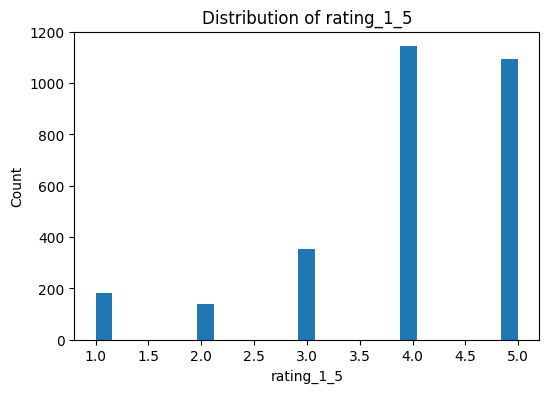

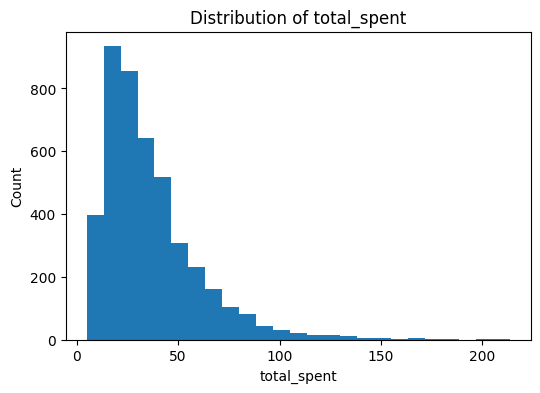

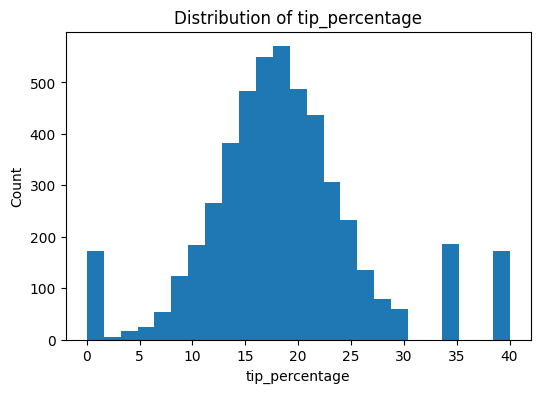

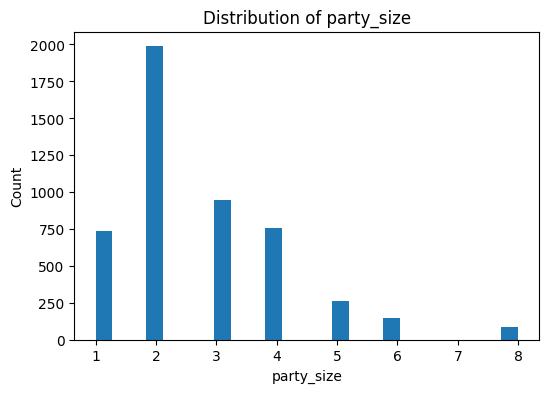

C:\Users\Bálint\AppData\Local\Temp\ipykernel_12756\934036804.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, showfliers=False)


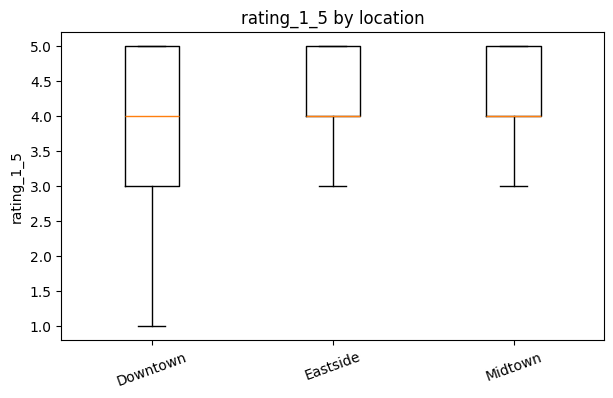

In [7]:
# Step 7 — Quick histograms (no seaborn, keep it simple)

def hist(df: pd.DataFrame, col: str, bins: int = 30):
    if col not in df.columns: 
        logger.info(f"Column {col} not in dataframe.")
        return
    series = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(series) == 0:
        logger.info(f"No numeric data in {col} to plot.")
        return
    plt.figure(figsize=(6,4))
    plt.hist(series, bins=bins)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

numeric_cols = ["rating_1_5", "total_spent", "tip_percentage", "party_size"]
for c in numeric_cols:
    hist(reviews, c, bins=25)

# Ratings per location (box-like view with simple plotting)
plt.figure(figsize=(7,4))
subset = reviews[["location", "rating_1_5"]].dropna()
if not subset.empty:
    # simple groupwise plotting without seaborn
    groups = [g.dropna().values for _, g in subset.groupby("location")["rating_1_5"]]
    labels = list(subset.groupby("location").groups.keys())
    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.title("rating_1_5 by location")
    plt.ylabel("rating_1_5")
    plt.xticks(rotation=20)
    plt.show()
else:
    logger.info("No rating_1_5 data to plot by location.")


In [8]:
# Step 8 — Next checks to consider (not all must be implemented now):

# 1) Duplicate detection beyond exact review_id (e.g., same text+date+name)
dupe_keys = ["customer_name", "review_text", "review_date", "restaurant_name"]
maybe_dupes = (
    reviews
    .assign(_text_norm = reviews["review_text"].astype("string").str.lower().str.replace(r"\s+", " ", regex=True))
    .groupby(["customer_name", "_text_norm", "review_date", "restaurant_name"], dropna=False)
    .size().sort_values(ascending=False)
)
display(maybe_dupes.head(10))

# 2) Outliers: suspiciously high total_spent / tip_percentage
outliers_spent = reviews[reviews["total_spent"] > reviews["total_spent"].quantile(0.99)]
display(outliers_spent[["total_spent", "tip_amount", "tip_percentage", "source_file"]].head())

# 3) Basic text length heuristics (very short or extremely long)
if "review_text" in reviews.columns:
    reviews["review_length"] = reviews["review_text"].astype("string").str.len()
    display(reviews["review_length"].describe())

# 4) Simple keyword flags you might want to use later for sentiment/rag filters
KEYWORDS_WAIT = ["wait", "waiting", "queue", "line", "delay"]
if "review_text" in reviews.columns:
    rt = reviews["review_text"].astype("string").str.lower()
    reviews["mentions_wait"] = rt.apply(lambda x: any(k in x for k in KEYWORDS_WAIT) if isinstance(x, str) else False)
    logger.info(f"Rows mentioning waiting: {reviews['mentions_wait'].sum():,}")


customer_name  _text_norm                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

,total_spent,tip_amount,tip_percentage,source_file
83,171.61,0.00,0.0,tastetrend_downtown_reviews.csv
2508,131.30,13.77,10.5,tastetrend_midtown_reviews.txt
2517,136.09,22.66,16.7,tastetrend_midtown_reviews.txt
2622,130.64,0.00,0.0,tastetrend_midtown_reviews.txt
3290,131.75,46.11,35.0,tastetrend_uptown_reviews.csv


count        3423.0
mean     589.196611
std      515.522159
min            58.0
25%           217.0
50%           436.0
75%           750.0
max          4552.0
Name: review_length, dtype: Float64

[INFO] Rows mentioning waiting: 1,055


In [9]:
# Step 9 — Save a light, standardized snapshot for later steps (local only)
SNAP_PATH = PROJECT_ROOT / "data" / "processed_exploration.parquet"
cols_to_save = [c for c in STANDARD_COLS if c != "rating_scale"] + ["review_length", "mentions_wait"]
cols_to_save = [c for c in cols_to_save if c in reviews.columns]
reviews[cols_to_save].to_parquet(SNAP_PATH, index=False)
logger.info(f"Saved exploration snapshot to: {SNAP_PATH}")


[INFO] Saved exploration snapshot to: c:\Users\Bálint\Documents\Pet_projects\tastetrend_analytics_genai\data\processed_exploration.parquet
